<a href="https://colab.research.google.com/github/PetrGavrilin/VKR_URFU/blob/main/VKR_part3_LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Линейная регрессия</h1>

In [647]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet, ElasticNetCV, SGDRegressor
from sklearn.model_selection import RandomizedSearchCV # для поиска при случайном сэмплирование гиперпараметров
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

In [648]:
try:
  import bottleneck as bn
except:
  !pip install bottleneck
  import bottleneck as bn

In [649]:
# Загрузка файла с функциями, как библиотеки
import sys
sys.path.append('/content')
from vkr_function import print_scores, plot_predict, my_test_train_split

In [650]:
# Загрузка преподготовленных данных
Y = pd.read_csv('/content/flow_rate.csv')
X_tsfel = np.genfromtxt('/content/X_tsfel.csv', delimiter=',')
X_tsfel_savgol = np.genfromtxt('/content/X_tsfel_savgol.csv', delimiter=',')
X_tsfel_rol = np.genfromtxt('/content/X_tsfel_rol.csv', delimiter=',')
borders = pd.read_csv('/content/borders.csv').values.tolist()[0]

Построим модель линейной регрессии на данных, к которым не применялось сглаживание

In [651]:
Y = np.array(Y['Et'])
X = np.array(X_tsfel)[1:]

In [652]:
X_train, y_train, X_test, y_test, i_test = my_test_train_split(X, Y, borders)

In [653]:
Modellica = [
    LinearRegression(),
    Lasso(), Ridge(),
    ElasticNetCV(max_iter = 10000),
    RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10]),
    SGDRegressor()]

scores = pd.DataFrame(index=['mse', 'rmse', 'r2'])

for model in Modellica:
  model.fit(X_train, y_train)
  y_predict = model.predict(X_test)
  scores.insert(
      len(scores.columns),
      model,
      [mse(y_test,y_predict),mse(y_test,y_predict,squared=False),r2_score(y_test,y_predict)]
      )

scores

,LinearRegression(),Lasso(),Ridge(),ElasticNetCV(max_iter=10000),"RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10])",SGDRegressor()
mse,0.001581,0.518017,0.001127,0.001110,0.001125,0.074140
rmse,0.039758,0.719734,0.033576,0.033311,0.033539,0.272286
r2,0.996949,-0.000018,0.997824,0.997858,0.997829,0.856875


In [654]:
LM = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10])

In [655]:
# Обучение модели и вывод метрик
LM.fit(X_train, y_train)
y_predict = LM.predict(X_test)
print_scores(y_test, y_predict, True)


Ошибка на тестовых данных
MSE: 0.00112
RMSE: 0.03354
R2 : 0.99783


In [656]:
y_predict_tr = LM.predict(X_train)
print_scores(y_train, y_predict_tr, False)

Ошибка на тренировочных данных
MSE: 0.00083
RMSE: 0.02876
R2 : 0.99840


In [657]:
y_predict_all = LM.predict(X)
print_scores(Y, y_predict_all)

Ошибка на полных данных
MSE: 0.00086
RMSE: 0.02927
R2 : 0.99834


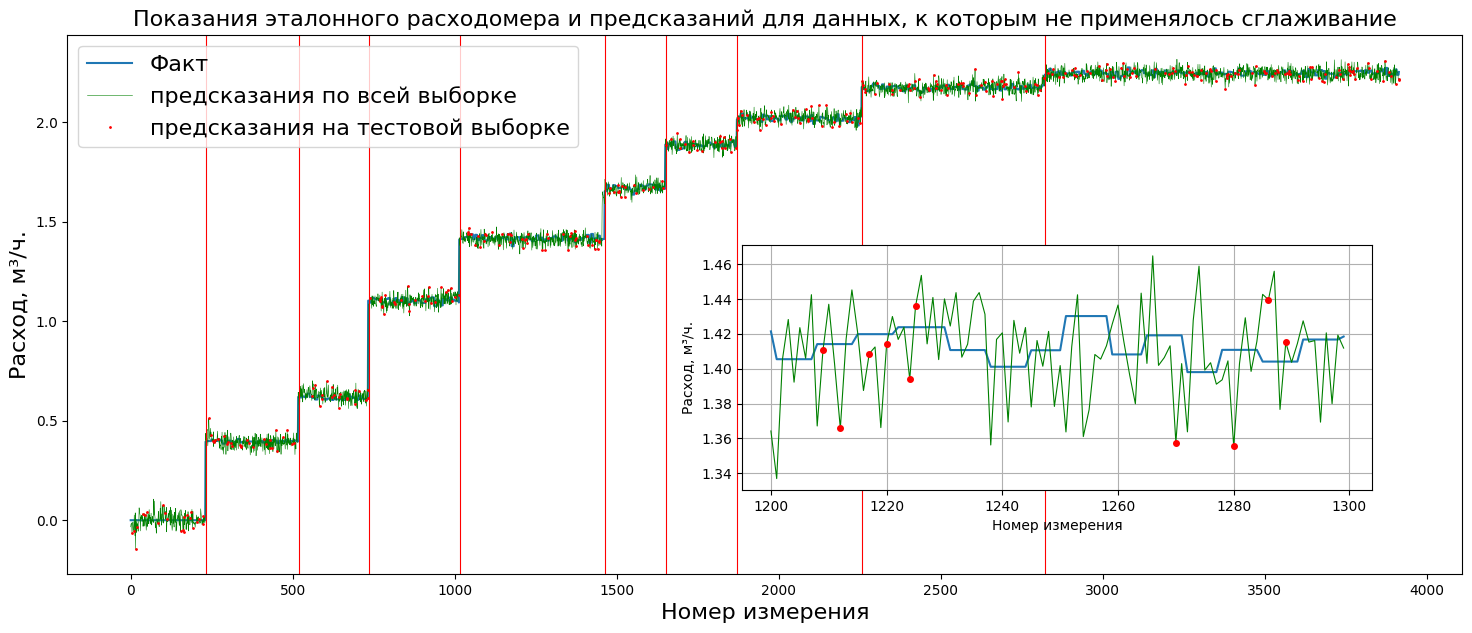

In [658]:
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="данных, к которым не применялось сглаживание")

In [659]:
y_rolling_all = bn.move_mean(y_predict_all, window=3, min_count=1)
y_rolling_test = bn.move_mean(y_predict, window=3, min_count=1)

In [660]:
y_rolling_all

array([-0.03323159, -0.02653541, -0.02319684, ...,  2.23803352,
        2.2265767 ,  2.21449157])

In [661]:
print_scores(Y, y_rolling_all)

Ошибка на полных данных
MSE: 0.00050
RMSE: 0.02238
R2 : 0.99903


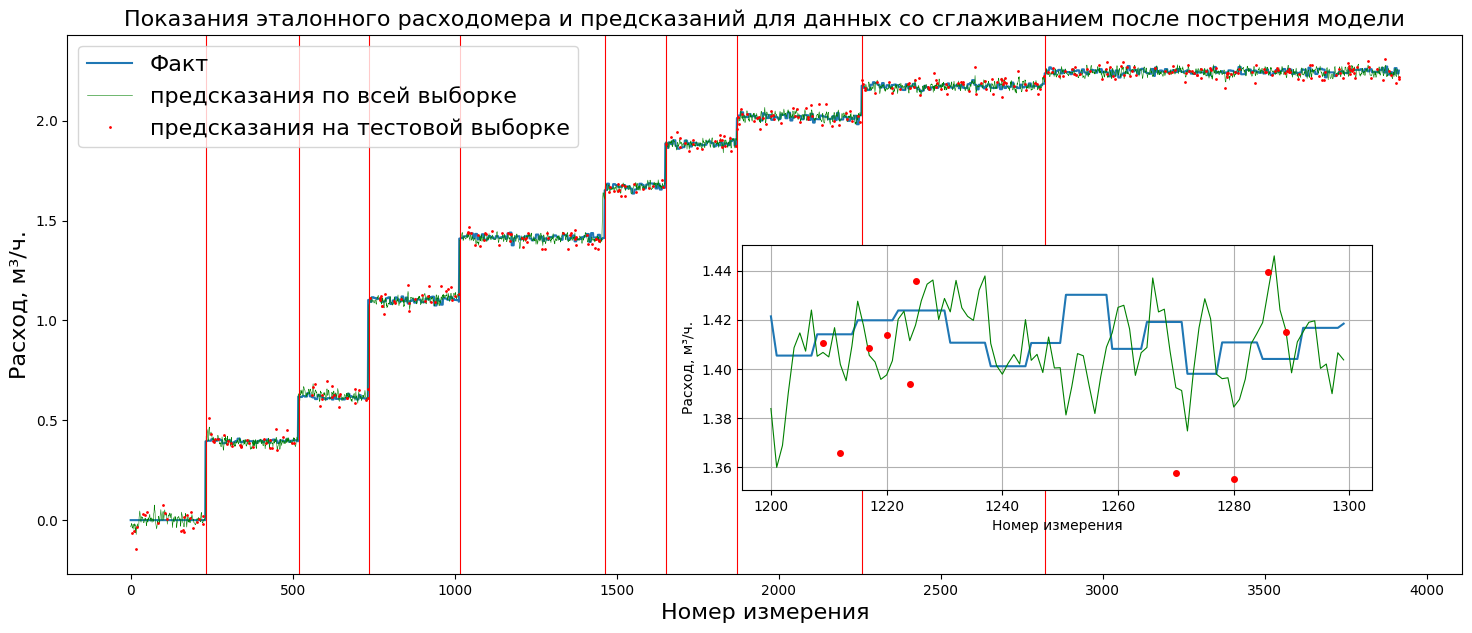

In [662]:
plot_predict(Y, i_test, y_predict, y_rolling_all, borders, text="данных со сглаживанием после пострения модели")

In [663]:
l_ = len(Y)

i_test = list(range(borders[3],borders[4]))

i_train = list(range(0,l_))
for x1 in i_test:
  i_train.remove(x1)

X_train = X[i_train,:]
y_train = Y[i_train]

X_test = X[i_test,:]
y_test = Y[i_test]

print(len(X_train), len(y_train))

3466 3466


In [664]:
scores = pd.DataFrame(index=['mse', 'rmse', 'r2'])

for model in Modellica:
  model.fit(X_train, y_train)
  y_predict = model.predict(X_test)
  scores.insert(
      len(scores.columns),
      model,
      [mse(y_test,y_predict),mse(y_test,y_predict,squared=False),r2_score(y_test,y_predict)]
      )

scores

,LinearRegression(),Lasso(),Ridge(),ElasticNetCV(max_iter=10000),"RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10])",SGDRegressor()
mse,0.002304,0.058269,0.002300,0.002336,0.002302,0.371044
rmse,0.048003,0.241389,0.047956,0.048333,0.047980,0.609134
r2,-7.878294,-223.502675,-7.860737,-8.000489,-7.869789,-1428.587975


In [665]:
LM = Ridge()

In [666]:
# Обучение модели и вывод метрик
LM.fit(X_train, y_train)
y_predict = LM.predict(X_test)
print_scores(y_test, y_predict, True)

Ошибка на тестовых данных
MSE: 0.00230
RMSE: 0.04796
R2 : -7.86074


In [667]:
y_predict_tr = LM.predict(X_train)
print_scores(y_train, y_predict_tr, False)

Ошибка на тренировочных данных
MSE: 0.00071
RMSE: 0.02669
R2 : 0.99877


In [668]:
y_predict_all = LM.predict(X)
print_scores(Y, y_predict_all)

Ошибка на полных данных
MSE: 0.00089
RMSE: 0.02991
R2 : 0.99827


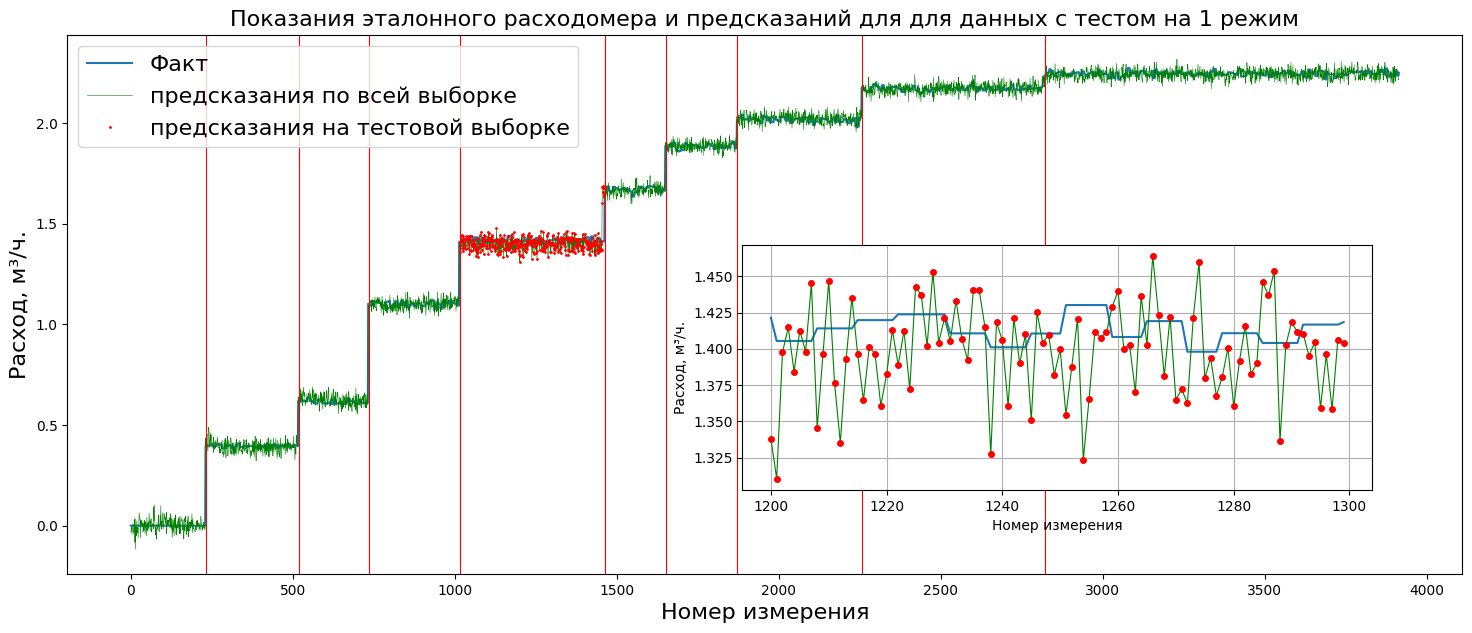

In [669]:
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="для данных с тестом на 1 режим")

In [670]:
Y[1015:1464].sum()/(1464-1015)

1.4169322693003341

In [671]:
y_predict_all[1015:1464].sum()/(1464-1015)

1.4050364800734307

In [672]:
y_rolling_all = bn.move_mean(y_predict_all, window=12, min_count=1)
y_rolling_train = bn.move_mean(y_predict_tr, window=12, min_count=1)
y_rolling_test = bn.move_mean(y_predict, window=12, min_count=1)

In [673]:
print_scores(y_test, y_rolling_test, True)
print()
print_scores(y_train, y_rolling_train, True)
print()
print_scores(Y, y_rolling_all, True)

Ошибка на тестовых данных
MSE: 0.00063
RMSE: 0.02502
R2 : -1.41164

Ошибка на тестовых данных
MSE: 0.00095
RMSE: 0.03077
R2 : 0.99836

Ошибка на тестовых данных
MSE: 0.00075
RMSE: 0.02746
R2 : 0.99854


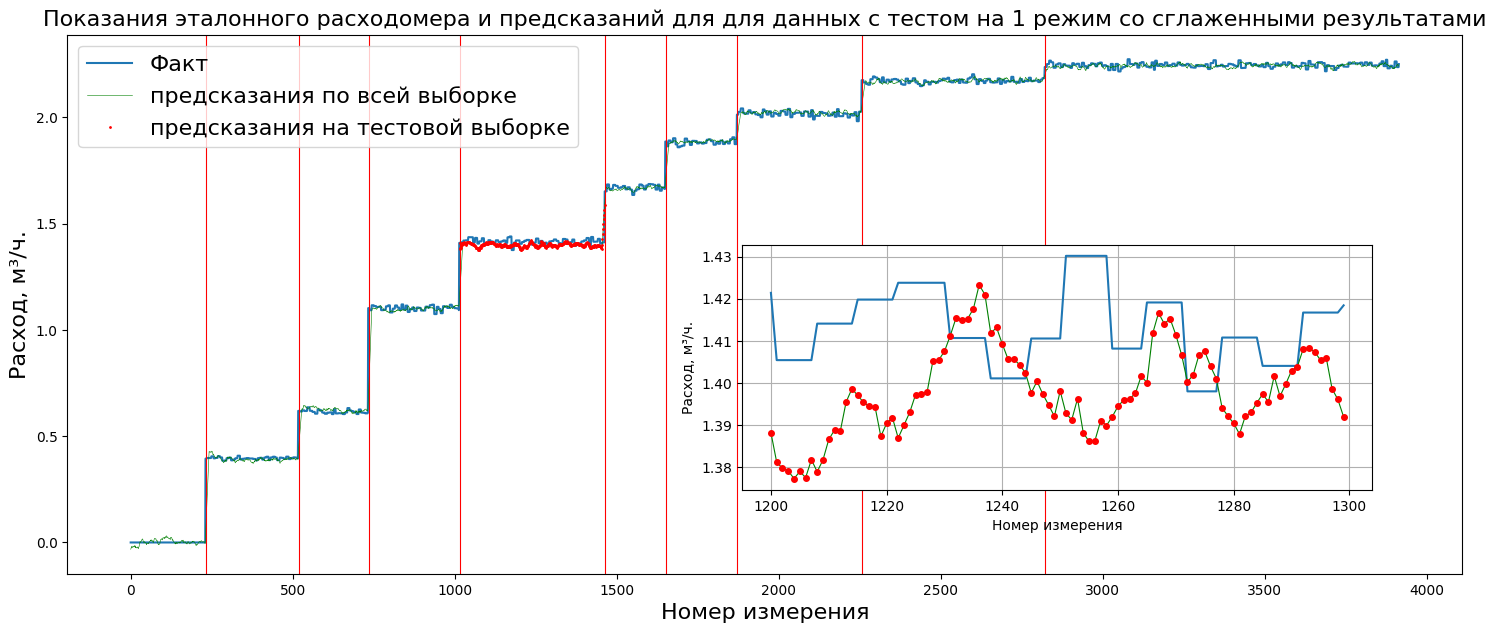

In [674]:
plot_predict(Y, i_test, y_rolling_test, y_rolling_all, borders, text="для данных с тестом на 1 режим со сглаженными результатами")

Из колебаний графика предсказаний вокруг фактических данных, а также учитывая построенный ранее график из исходных данных по разности времён, можно предположить, что для исключения колебаний показания расхода необходимо применить сглаживание к исходным данным.

Обучение модели на дополнительно обработанных данных с помощью функции Савицкого-Голея

In [675]:
X = np.array(X_tsfel_savgol)[1:]


In [676]:
X_train, y_train, X_test, y_test, i_test = my_test_train_split(X, Y, borders)

In [677]:
scores = pd.DataFrame(index=['mse', 'rmse', 'r2'])

for model in Modellica:
  model.fit(X_train, y_train)
  y_predict = model.predict(X_test)
  scores.insert(
      len(scores.columns),
      model,
      [mse(y_test,y_predict),mse(y_test,y_predict,squared=False),r2_score(y_test,y_predict)]
      )

scores

,LinearRegression(),Lasso(),Ridge(),ElasticNetCV(max_iter=10000),"RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10])",SGDRegressor()
mse,0.000389,0.515623,0.000388,0.000554,0.000387,2.555480e+13
rmse,0.019712,0.718069,0.019698,0.023544,0.019669,5.055176e+06
r2,0.999246,-0.000029,0.999247,0.998925,0.999250,-4.956245e+13


In [678]:
LM = LinearRegression()

In [679]:
# Обучение модели и вывод метрик
LM.fit(X_train, y_train)
y_predict = LM.predict(X_test)
print_scores(y_test, y_predict, True)

Ошибка на тестовых данных
MSE: 0.00039
RMSE: 0.01971
R2 : 0.99925


In [680]:
y_predict_tr = LM.predict(X_train)
print_scores(y_train, y_predict_tr, False)

Ошибка на тренировочных данных
MSE: 0.00026
RMSE: 0.01618
R2 : 0.99949


In [681]:
y_predict_all = LM.predict(X)
print_scores(Y, y_predict_all)

Ошибка на полных данных
MSE: 0.00027
RMSE: 0.01657
R2 : 0.99947


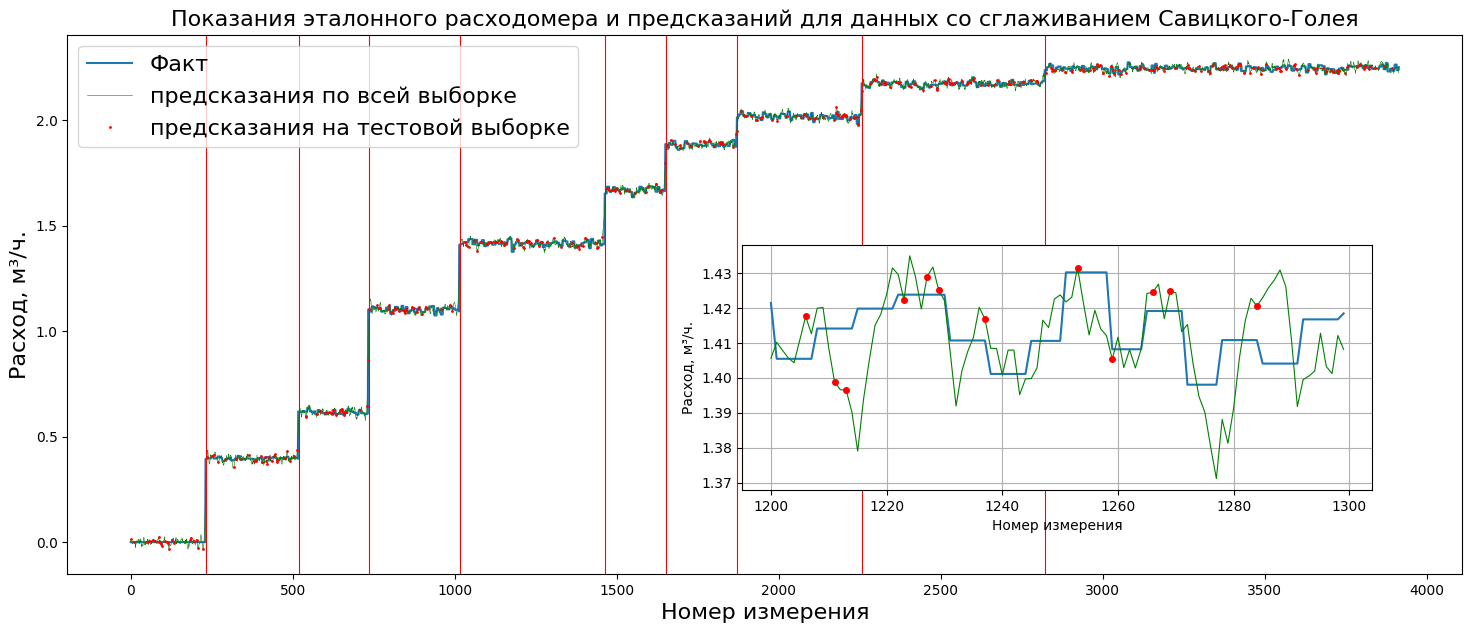

In [682]:
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="данных со сглаживанием Савицкого-Голея")

Проверим работу модели, приняв за тестовую выборку один из режимов расхода

In [683]:
l_ = len(Y)

i_test = list(range(borders[3],borders[4]))

i_train = list(range(0,l_))
for x1 in i_test:
  i_train.remove(x1)

X_train = X[i_train,:]
y_train = Y[i_train]

X_test = X[i_test,:]
y_test = Y[i_test]

print(len(X_train), len(y_train))

3466 3466


In [684]:
scores = pd.DataFrame(index=['mse', 'rmse', 'r2'])

for model in Modellica:
  model.fit(X_train, y_train)
  y_predict = model.predict(X_test)
  scores.insert(
      len(scores.columns),
      model,
      [mse(y_test,y_predict),mse(y_test,y_predict,squared=False),r2_score(y_test,y_predict)]
      )

scores

,LinearRegression(),Lasso(),Ridge(),ElasticNetCV(max_iter=10000),"RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10])",SGDRegressor()
mse,0.002090,0.058269,0.001896,0.001558,0.002052,2.479137e+16
rmse,0.045715,0.241389,0.043542,0.039473,0.045303,1.574528e+08
r2,-7.052043,-223.502675,-6.304805,-5.003139,-6.907491,-9.551818e+19


In [685]:
LM = Ridge()

In [686]:
# Обучение модели и вывод метрик
LM.fit(X_train, y_train)
y_predict = LM.predict(X_test)
print_scores(y_test, y_predict, True)

Ошибка на тестовых данных
MSE: 0.00190
RMSE: 0.04354
R2 : -6.30480


In [687]:
y_predict_tr = LM.predict(X_train)
print_scores(y_train, y_predict_tr, False)

Ошибка на тренировочных данных
MSE: 0.00022
RMSE: 0.01470
R2 : 0.99963


In [688]:
y_predict_all = LM.predict(X)
print_scores(Y, y_predict_all)

Ошибка на полных данных
MSE: 0.00041
RMSE: 0.02022
R2 : 0.99921


In [689]:
LM.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

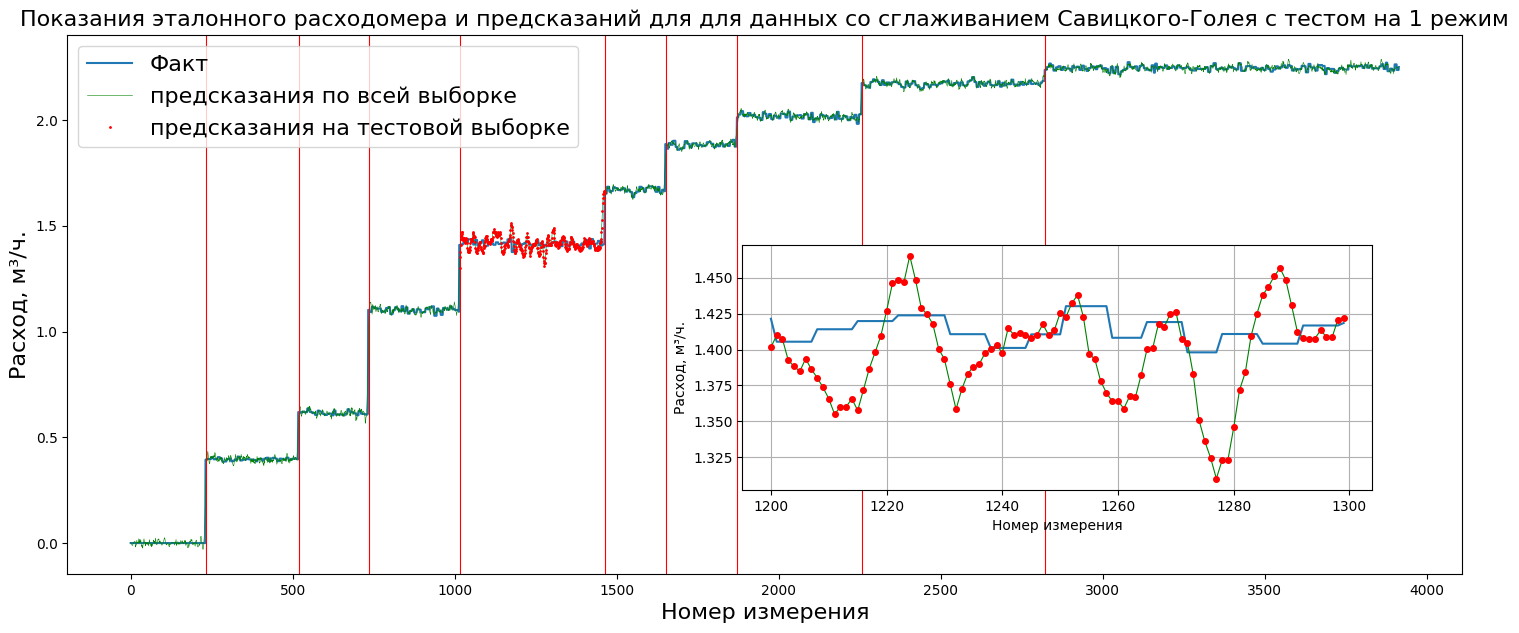

In [690]:
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="для данных со сглаживанием Савицкого-Голея с тестом на 1 режим")

In [691]:
Y[1015:1464].sum()/(1464-1015)

1.4169322693003341

In [692]:
y_predict_all[1015:1464].sum()/(1464-1015)

1.4198378799628644

Построим линейную модель для данных со скользящим средним

In [693]:
X = np.array(X_tsfel_rol)[1:]

In [694]:
X_train, y_train, X_test, y_test, i_test = my_test_train_split(X, Y, borders)

In [695]:
scores = pd.DataFrame(index=['mse', 'rmse', 'r2'])

for model in Modellica:
  model.fit(X_train, y_train)
  y_predict = model.predict(X_test)
  scores.insert(
      len(scores.columns),
      model,
      [mse(y_test,y_predict),mse(y_test,y_predict,squared=False),r2_score(y_test,y_predict)]
      )

scores

,LinearRegression(),Lasso(),Ridge(),ElasticNetCV(max_iter=10000),"RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10])",SGDRegressor()
mse,0.000684,0.515652,0.000675,0.001350,0.000675,9.025087e+21
rmse,0.026155,0.718089,0.025973,0.036743,0.025973,9.500046e+10
r2,0.998673,-0.000048,0.998692,0.997382,0.998692,-1.750312e+22


In [696]:
LM = Ridge()

In [697]:
# Обучение модели и вывод метрик
LM.fit(X_train, y_train)
y_predict = LM.predict(X_test)
print_scores(y_test, y_predict, True)

Ошибка на тестовых данных
MSE: 0.00067
RMSE: 0.02597
R2 : 0.99869


In [698]:
y_predict_tr = LM.predict(X_train)
print_scores(y_train, y_predict_tr, False)

Ошибка на тренировочных данных
MSE: 0.00039
RMSE: 0.01978
R2 : 0.99924


In [699]:
y_predict_all = LM.predict(X)
print_scores(Y, y_predict_all)

Ошибка на полных данных
MSE: 0.00042
RMSE: 0.02048
R2 : 0.99919


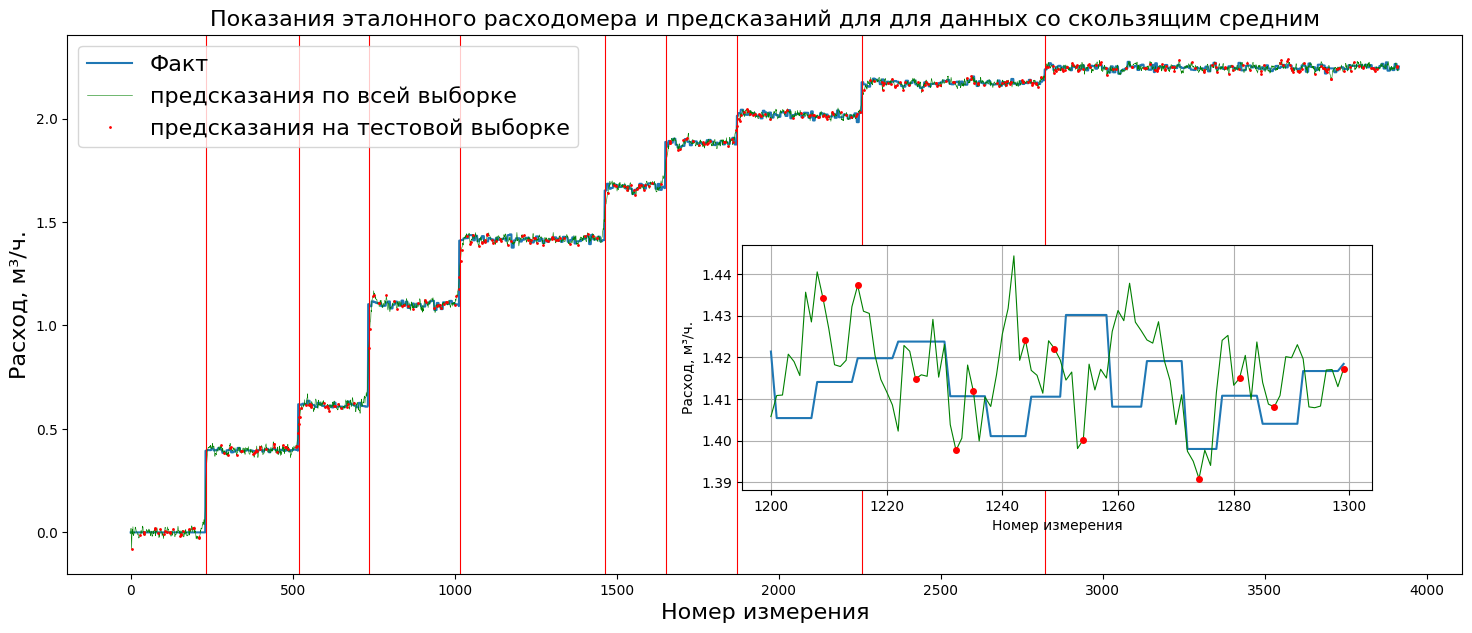

In [700]:
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="для данных со скользящим средним")